# **Desafío - Segmentación**

## Javier Rebull

## Nov 2024

### **Contexto:**

La empresa desea mejorar la efectividad de sus campañas de marketing segmentando a los usuarios de tarjetas de débito según sus patrones de gasto en distintos comercios. La segmentación permitirá personalizar las ofertas y promociones, aumentando la satisfacción del cliente y el uso de la tarjeta.

### **Objetivo:**

Desarrollar un modelo de segmentación que agrupe a los usuarios de tarjetas de débito según sus comportamientos de gasto en diferentes tipos de comercios. Este modelo ayudará a la empresa a:

- Identificar segmentos clave.
- Diseñar campañas de marketing específicas para cada grupo.

In [1]:
# [1] Importación de Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
# Acceso a Google Drive desde Colab
from google.colab import drive
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
# [2] Configuración de Google Drive y carga de datos
# Montar Google Drive
drive.mount("/content/drive", force_remount=True)
DIR = '/content/drive/MyDrive/RetoSegmentacion/'
os.chdir(DIR)

# Cargar datos
file_path = "segmentation_data_recruitment.csv"
data = pd.read_csv(file_path)
print("Primeras filas del dataset:")
data.head()

Mounted at /content/drive
Primeras filas del dataset:


,index,user,age,creation_date,registration_channel,creation_flow,user_type,first_transaction_date_withdrawals,last_transaction_date_withdrawals,total_tickets_withdrawals,...,instore_transaction_count_transfers,avg_days_between_transactions_transfers,avg_transfers_per_week,first_transaction_date_inflow,last_transaction_date_inflow,total_tickets_inflow,avg_amount_inflow,instore_transaction_count_inflow,avg_days_between_transactions_inflow,avg_inflow_per_week
0,7225857,FQuOVxm4Jw,45,2023-11-30 13:49:23.250000+00:00,STORE,STORE,PHYSICAL,2023-12-10,2023-12-12,NaN,...,NaN,NaN,NaN,2023-12-01,2023-12-12,NaN,NaN,NaN,NaN,NaN
1,1472007,5uFb43TN8o,37,2021-12-16 17:18:19.859000+00:00,STORE,STORE,MIXED,2021-12-17,2021-12-18,NaN,...,NaN,NaN,NaN,2021-12-16,2021-12-18,NaN,NaN,NaN,NaN,NaN
2,7693158,CWp85LI7lK,47,2022-11-15 02:06:31.605000+00:00,STORE,STORE,MIXED,NaN,NaN,NaN,...,NaN,NaN,NaN,2022-11-15,2022-11-15,NaN,NaN,NaN,NaN,NaN
3,6005263,sjNCnMjHDH,59,2021-11-15 01:45:44.240000+00:00,SELF_ENRROLLED,APP,MIXED,2022-05-31,2024-05-12,1.0,...,0.0,12.594595,0.666667,2021-12-04,2024-06-30,80.0,19467.0375,7.0,3.771084,4.444444
4,2276327,q1p4841ENk,35,2022-05-05 00:28:45.073000+00:00,STORE,STORE,PHYSICAL,2022-05-12,2023-09-11,NaN,...,NaN,NaN,NaN,2022-05-05,2023-09-11,NaN,NaN,NaN,NaN,NaN


In [3]:
# [3] Análisis Exploratorio de Datos (EDA)
from tabulate import tabulate

def create_enhanced_summary(df):
    """
    Crea un resumen detallado y visualmente atractivo del dataset
    """
    # Crear DataFrame base con información de columnas
    numeric_data = df.select_dtypes(include=[np.number])

    column_summary = pd.DataFrame({
        'Column Name': df.columns,
        'Data Type': df.dtypes,
        'Non-Null Count': df.count(),
        'Nulls': df.isnull().sum().apply(lambda x: f"{x:,}"),
        'Null %': (df.isnull().sum() / len(df) * 100).round(2).apply(lambda x: f"{x:.2f}%")
    })

    # Agregar estadísticas para columnas numéricas
    column_summary['Min'] = numeric_data.min().reindex(df.columns).apply(
        lambda x: f"{x:,.2f}" if pd.notnull(x) else "N/A"
    )
    column_summary['Max'] = numeric_data.max().reindex(df.columns).apply(
        lambda x: f"{x:,.2f}" if pd.notnull(x) else "N/A"
    )
    column_summary['Avg'] = numeric_data.mean().reindex(df.columns).apply(
        lambda x: f"{x:,.2f}" if pd.notnull(x) else "N/A"
    )
    column_summary['Std'] = numeric_data.std().reindex(df.columns).apply(
        lambda x: f"{x:,.2f}" if pd.notnull(x) else "N/A"
    )

    # Agregar información de cardinalidad
    column_summary['Unique Values'] = df.nunique().apply(lambda x: f"{x:,}")

    return column_summary

def initial_exploration(df):
    """
    Realiza exploración inicial del dataset con resumen visual mejorado
    """
    # Número de filas y columnas
    num_rows, num_cols = df.shape

    # Crear encabezado con información básica
    print(f"""
╔══════════════════════════════════════════════╗
║           🎉 ANÁLISIS EXPLORATORIO 🎉        ║
╠══════════════════════════════════════════════╣
║  📊 Dimensiones del Dataset:                 ║
║  • Número de Filas: {num_rows:,}
║  • Número de Columnas: {num_cols}
║  • Memoria Utilizada: {df.memory_usage().sum() / 1024**2:.2f} MB
╚══════════════════════════════════════════════╝
    """)

    # Crear y mostrar tabla detallada
    column_summary = create_enhanced_summary(df)
    summary_table = tabulate(column_summary, headers='keys',
                           tablefmt='fancy_grid',
                           showindex=False)
    print("\n🔍 Resumen Detallado de Variables:")
    print(summary_table)

    # Información adicional
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    categorical_cols = df.select_dtypes(exclude=[np.number]).columns

    print(f"""
╔══════════════════════════════════════════════╗
║           📈 TIPOS DE VARIABLES 📊           ║
╠══════════════════════════════════════════════╣
║  • Variables Numéricas: {len(numeric_cols)}
║  • Variables Categóricas: {len(categorical_cols)}
╚══════════════════════════════════════════════╝
    """)

    # Mostrar primeras filas con estilo mejorado
    print("\n👀 Vista Previa del Dataset:")
    display(df.head().style
           .set_properties(**{
               'background-color': '#1a1a1a',     # Fondo oscuro
               'color': '#e0e0e0',               # Texto gris claro
               'border-color': '#404040',        # Bordes gris oscuro
               'border-style': 'solid',
               'border-width': '1px',
               'text-align': 'left',
               'padding': '8px',
               'font-family': 'monospace'
           })
           .set_table_styles([
               {'selector': 'thead',
                'props': [('background-color', '#2d2d2d'),  # Encabezado un poco más claro
                         ('color', '#ffffff'),              # Texto blanco en encabezado
                         ('font-weight', 'bold'),
                         ('border-bottom', '2px solid #404040')]},
               {'selector': 'tbody tr:nth-of-type(odd)',
                'props': [('background-color', '#262626')]}, # Filas impares ligeramente más claras
           ])
           .format(precision=2))

    # Información sobre valores faltantes
    nulls = df.isnull().sum()
    if nulls.any():
        print("\n⚠️ Columnas con Valores Faltantes:")
        null_info = pd.DataFrame({
            'Columna': nulls[nulls > 0].index,
            'Valores Nulos': nulls[nulls > 0].values,
            'Porcentaje': (nulls[nulls > 0] / len(df) * 100).round(2)
        })
        print(tabulate(null_info, headers='keys', tablefmt='fancy_grid', showindex=False))

    # Estadísticas básicas
    print("\n📊 Resumen Estadístico de Variables Numéricas:")
    print(df.describe().round(2).to_string())

# Ejecutar exploración inicial mejorada
initial_exploration(data)


╔══════════════════════════════════════════════╗
║           🎉 ANÁLISIS EXPLORATORIO 🎉        ║
╠══════════════════════════════════════════════╣
║  📊 Dimensiones del Dataset:                 ║
║  • Número de Filas: 100,000            
║  • Número de Columnas: 35            
║  • Memoria Utilizada: 26.70 MB
╚══════════════════════════════════════════════╝
    

🔍 Resumen Detallado de Variables:
╒═══════════════════════════════════════════╤═════════════╤══════════════════╤═════════╤══════════╤═══════╤═══════════════╤══════════════╤══════════════╤═════════════════╕
│ Column Name                               │ Data Type   │   Non-Null Count │ Nulls   │ Null %   │ Min   │ Max           │ Avg          │ Std          │ Unique Values   │
╞═══════════════════════════════════════════╪═════════════╪══════════════════╪═════════╪══════════╪═══════╪═══════════════╪══════════════╪══════════════╪═════════════════╡
│ index                                     │ int64       │           100000 │ 0      

,index,user,age,creation_date,registration_channel,creation_flow,user_type,first_transaction_date_withdrawals,last_transaction_date_withdrawals,total_tickets_withdrawals,avg_amount_withdrawals,instore_transaction_count_withdrawals,avg_days_between_transactions_withdrawals,avg_withdrawals_per_week,first_transaction_date_purchases,last_transaction_date_purchases,total_tickets_purchases,avg_amount_purchases,instore_transaction_count_purchases,avg_days_between_transactions_purchases,avg_purchases_per_week,first_transaction_date_transfers,last_transaction_date_transfers,total_tickets_transfers,avg_amount_transfers,instore_transaction_count_transfers,avg_days_between_transactions_transfers,avg_transfers_per_week,first_transaction_date_inflow,last_transaction_date_inflow,total_tickets_inflow,avg_amount_inflow,instore_transaction_count_inflow,avg_days_between_transactions_inflow,avg_inflow_per_week
0,7225857,FQuOVxm4Jw,45,2023-11-30 13:49:23.250000+00:00,STORE,STORE,PHYSICAL,2023-12-10,2023-12-12,nan,nan,nan,nan,nan,2023-12-02,2024-01-14,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,2023-12-01,2023-12-12,nan,nan,nan,nan,nan
1,1472007,5uFb43TN8o,37,2021-12-16 17:18:19.859000+00:00,STORE,STORE,MIXED,2021-12-17,2021-12-18,nan,nan,nan,nan,nan,2021-12-16,2021-12-25,nan,nan,nan,nan,nan,2021-12-16,2021-12-16,nan,nan,nan,nan,nan,2021-12-16,2021-12-18,nan,nan,nan,nan,nan
2,7693158,CWp85LI7lK,47,2022-11-15 02:06:31.605000+00:00,STORE,STORE,MIXED,nan,nan,nan,nan,nan,nan,nan,2023-02-14,2023-02-14,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,2022-11-15,2022-11-15,nan,nan,nan,nan,nan
3,6005263,sjNCnMjHDH,59,2021-11-15 01:45:44.240000+00:00,SELF_ENRROLLED,APP,MIXED,2022-05-31,2024-05-12,1.00,25000.00,1.00,33.90,0.06,2021-12-05,2024-06-30,89.00,14303.31,0.00,3.19,4.94,2021-12-08,2024-06-27,12.00,25000.00,0.00,12.59,0.67,2021-12-04,2024-06-30,80.00,19467.04,7.00,3.77,4.44
4,2276327,q1p4841ENk,35,2022-05-05 00:28:45.073000+00:00,STORE,STORE,PHYSICAL,2022-05-12,2023-09-11,nan,nan,nan,nan,nan,2023-05-23,2023-06-02,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,2022-05-05,2023-09-11,nan,nan,nan,nan,nan



⚠️ Columnas con Valores Faltantes:
╒═══════════════════════════════════════════╤═════════════════╤══════════════╕
│ Columna                                   │   Valores Nulos │   Porcentaje │
╞═══════════════════════════════════════════╪═════════════════╪══════════════╡
│ first_transaction_date_withdrawals        │           50799 │        50.8  │
├───────────────────────────────────────────┼─────────────────┼──────────────┤
│ last_transaction_date_withdrawals         │           50799 │        50.8  │
├───────────────────────────────────────────┼─────────────────┼──────────────┤
│ total_tickets_withdrawals                 │           62250 │        62.25 │
├───────────────────────────────────────────┼─────────────────┼──────────────┤
│ avg_amount_withdrawals                    │           62250 │        62.25 │
├───────────────────────────────────────────┼─────────────────┼──────────────┤
│ instore_transaction_count_withdrawals     │           62250 │        62.25 │
├───────────────

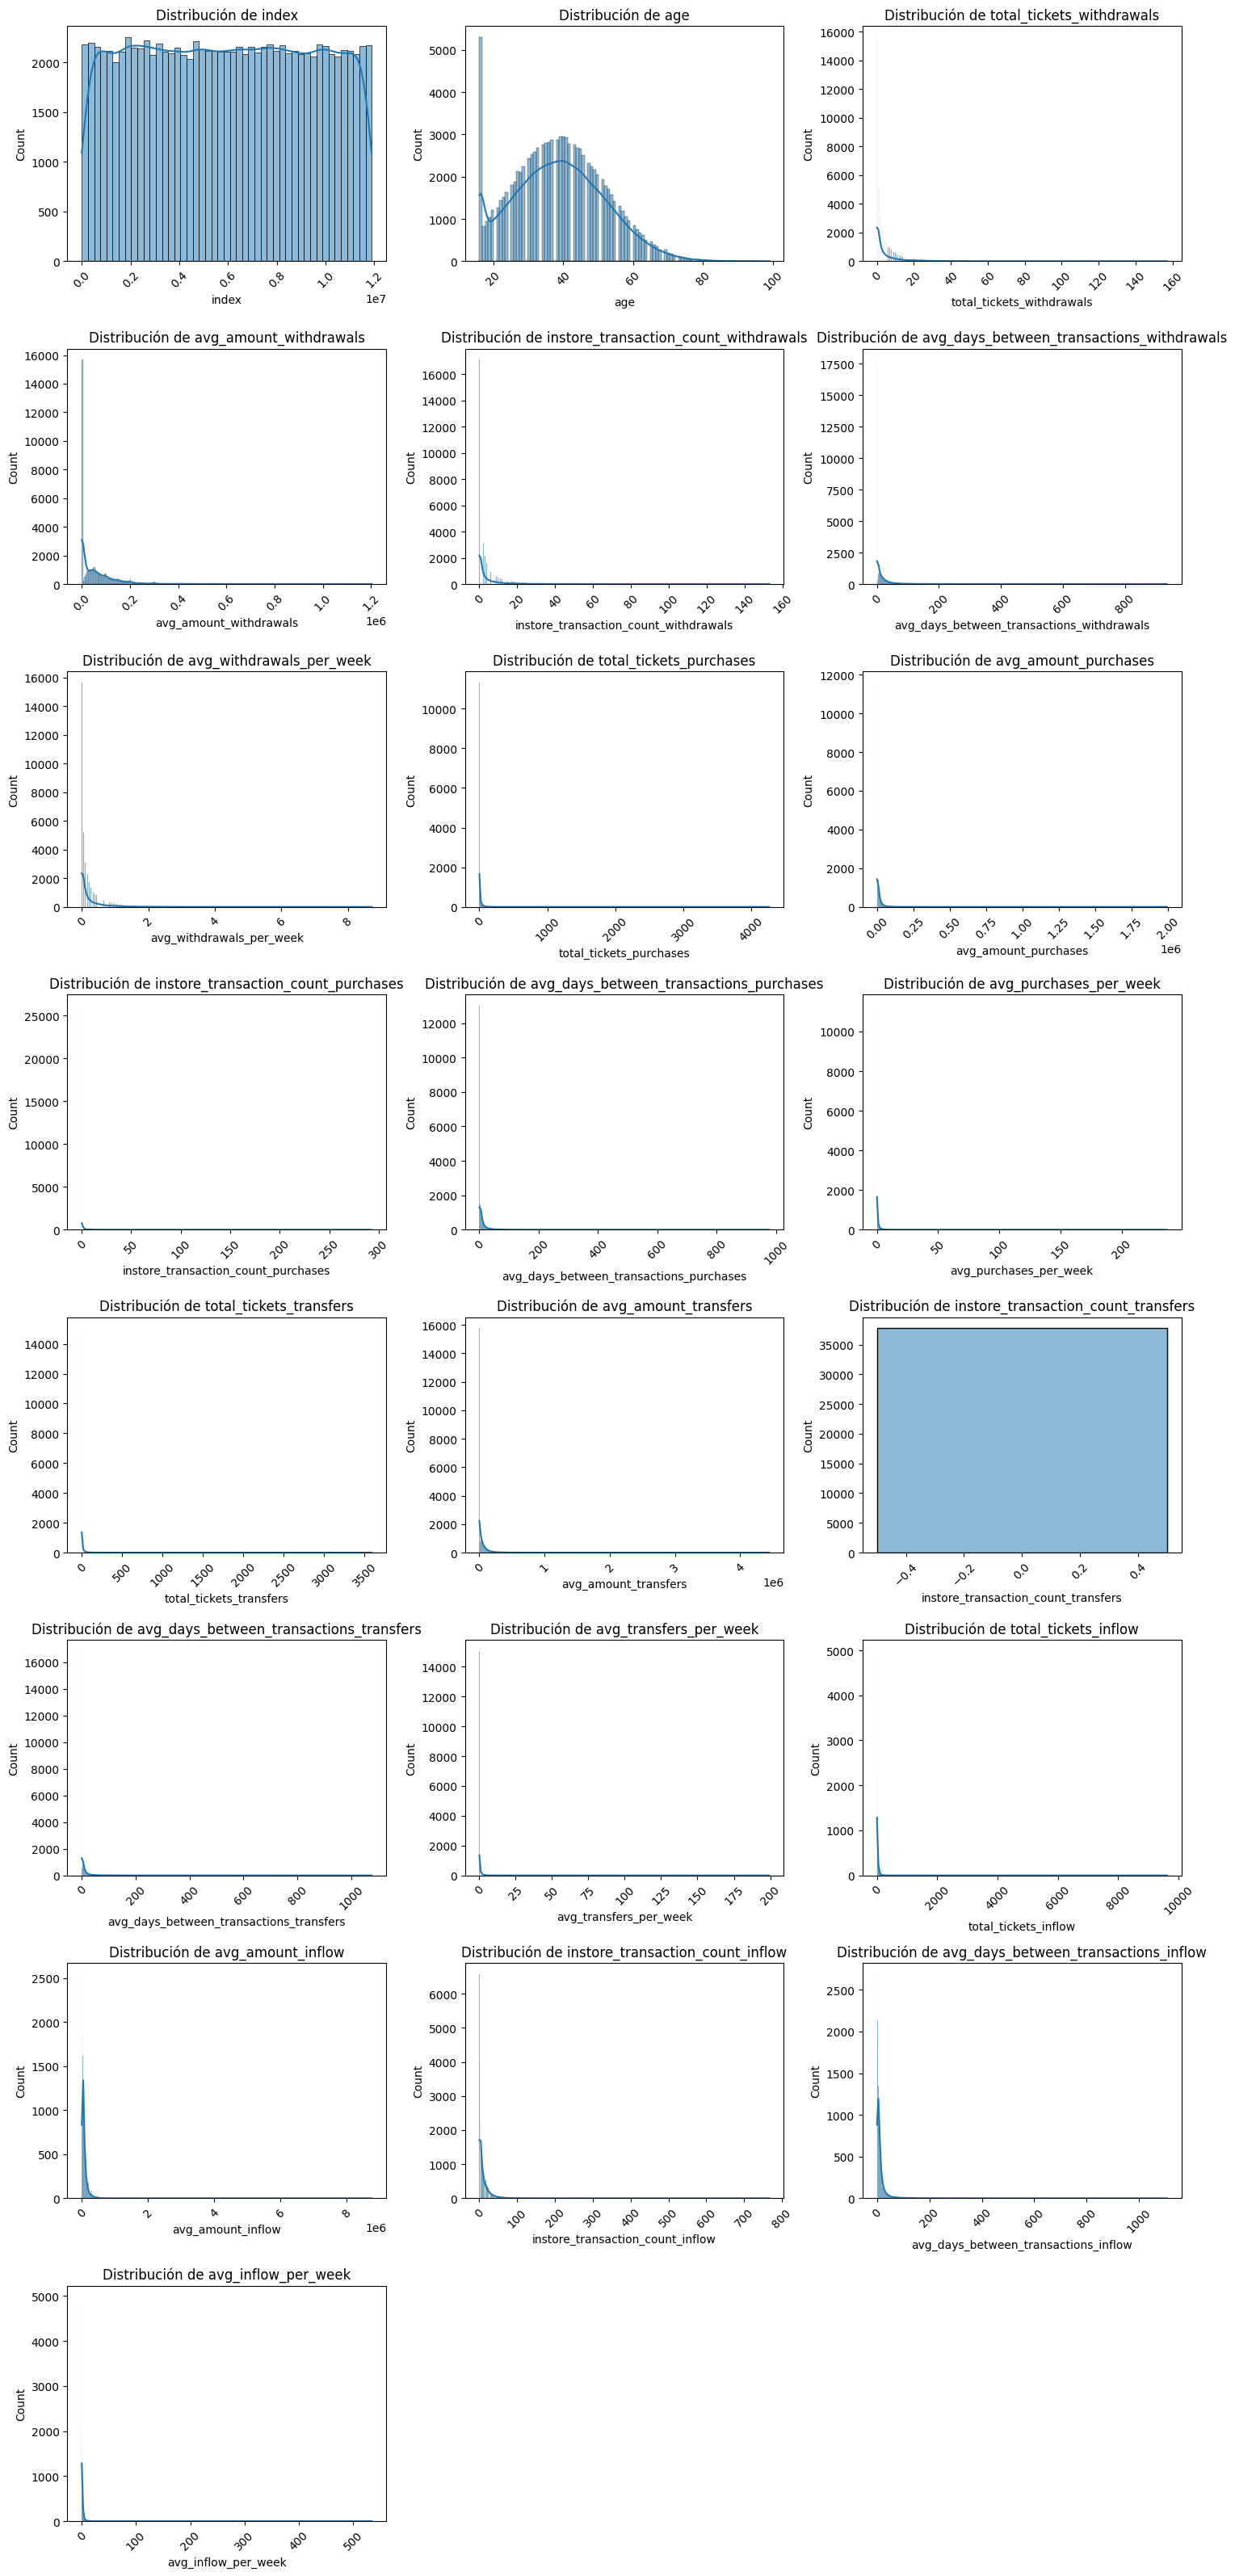


Estadísticas descriptivas de las variables numéricas:
              index            age  total_tickets_withdrawals  \
count  1.000000e+05  100000.000000               37750.000000   
mean   5.938018e+06      38.849920                   4.189060   
std    3.439612e+06      13.105903                   7.972458   
min    2.300000e+01      16.000000                   0.000000   
25%    2.951116e+06      29.000000                   0.000000   
50%    5.937868e+06      39.000000                   1.000000   
75%    8.908418e+06      48.000000                   5.000000   
max    1.190031e+07      99.000000                 157.000000   

       avg_amount_withdrawals  instore_transaction_count_withdrawals  \
count            3.775000e+04                           37750.000000   
mean             5.709509e+04                               3.626146   
std              8.713154e+04                               7.283176   
min              0.000000e+00                               0.000000   

In [4]:
# [4] Visualización de Distribuciones
def visualize_distributions(df):
    """
    Genera visualizaciones de las distribuciones de variables principales
    """
    # Obtener columnas numéricas
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    n_cols = len(numeric_cols)

    # Calcular número de filas y columnas necesarias para los subplots
    n_rows = (n_cols - 1) // 3 + 1  # 3 gráficos por fila
    n_cols_plot = min(3, n_cols)

    # Crear figura con tamaño adecuado
    plt.figure(figsize=(5*n_cols_plot, 4*n_rows))

    # Crear subplots para cada variable
    for i, column in enumerate(numeric_cols, 1):
        plt.subplot(n_rows, n_cols_plot, i)
        sns.histplot(df[column], kde=True)
        plt.title(f'Distribución de {column}')
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    # Imprimir estadísticas descriptivas
    print("\nEstadísticas descriptivas de las variables numéricas:")
    print(df[numeric_cols].describe())

# Ejecutar visualización de distribuciones
visualize_distributions(data)

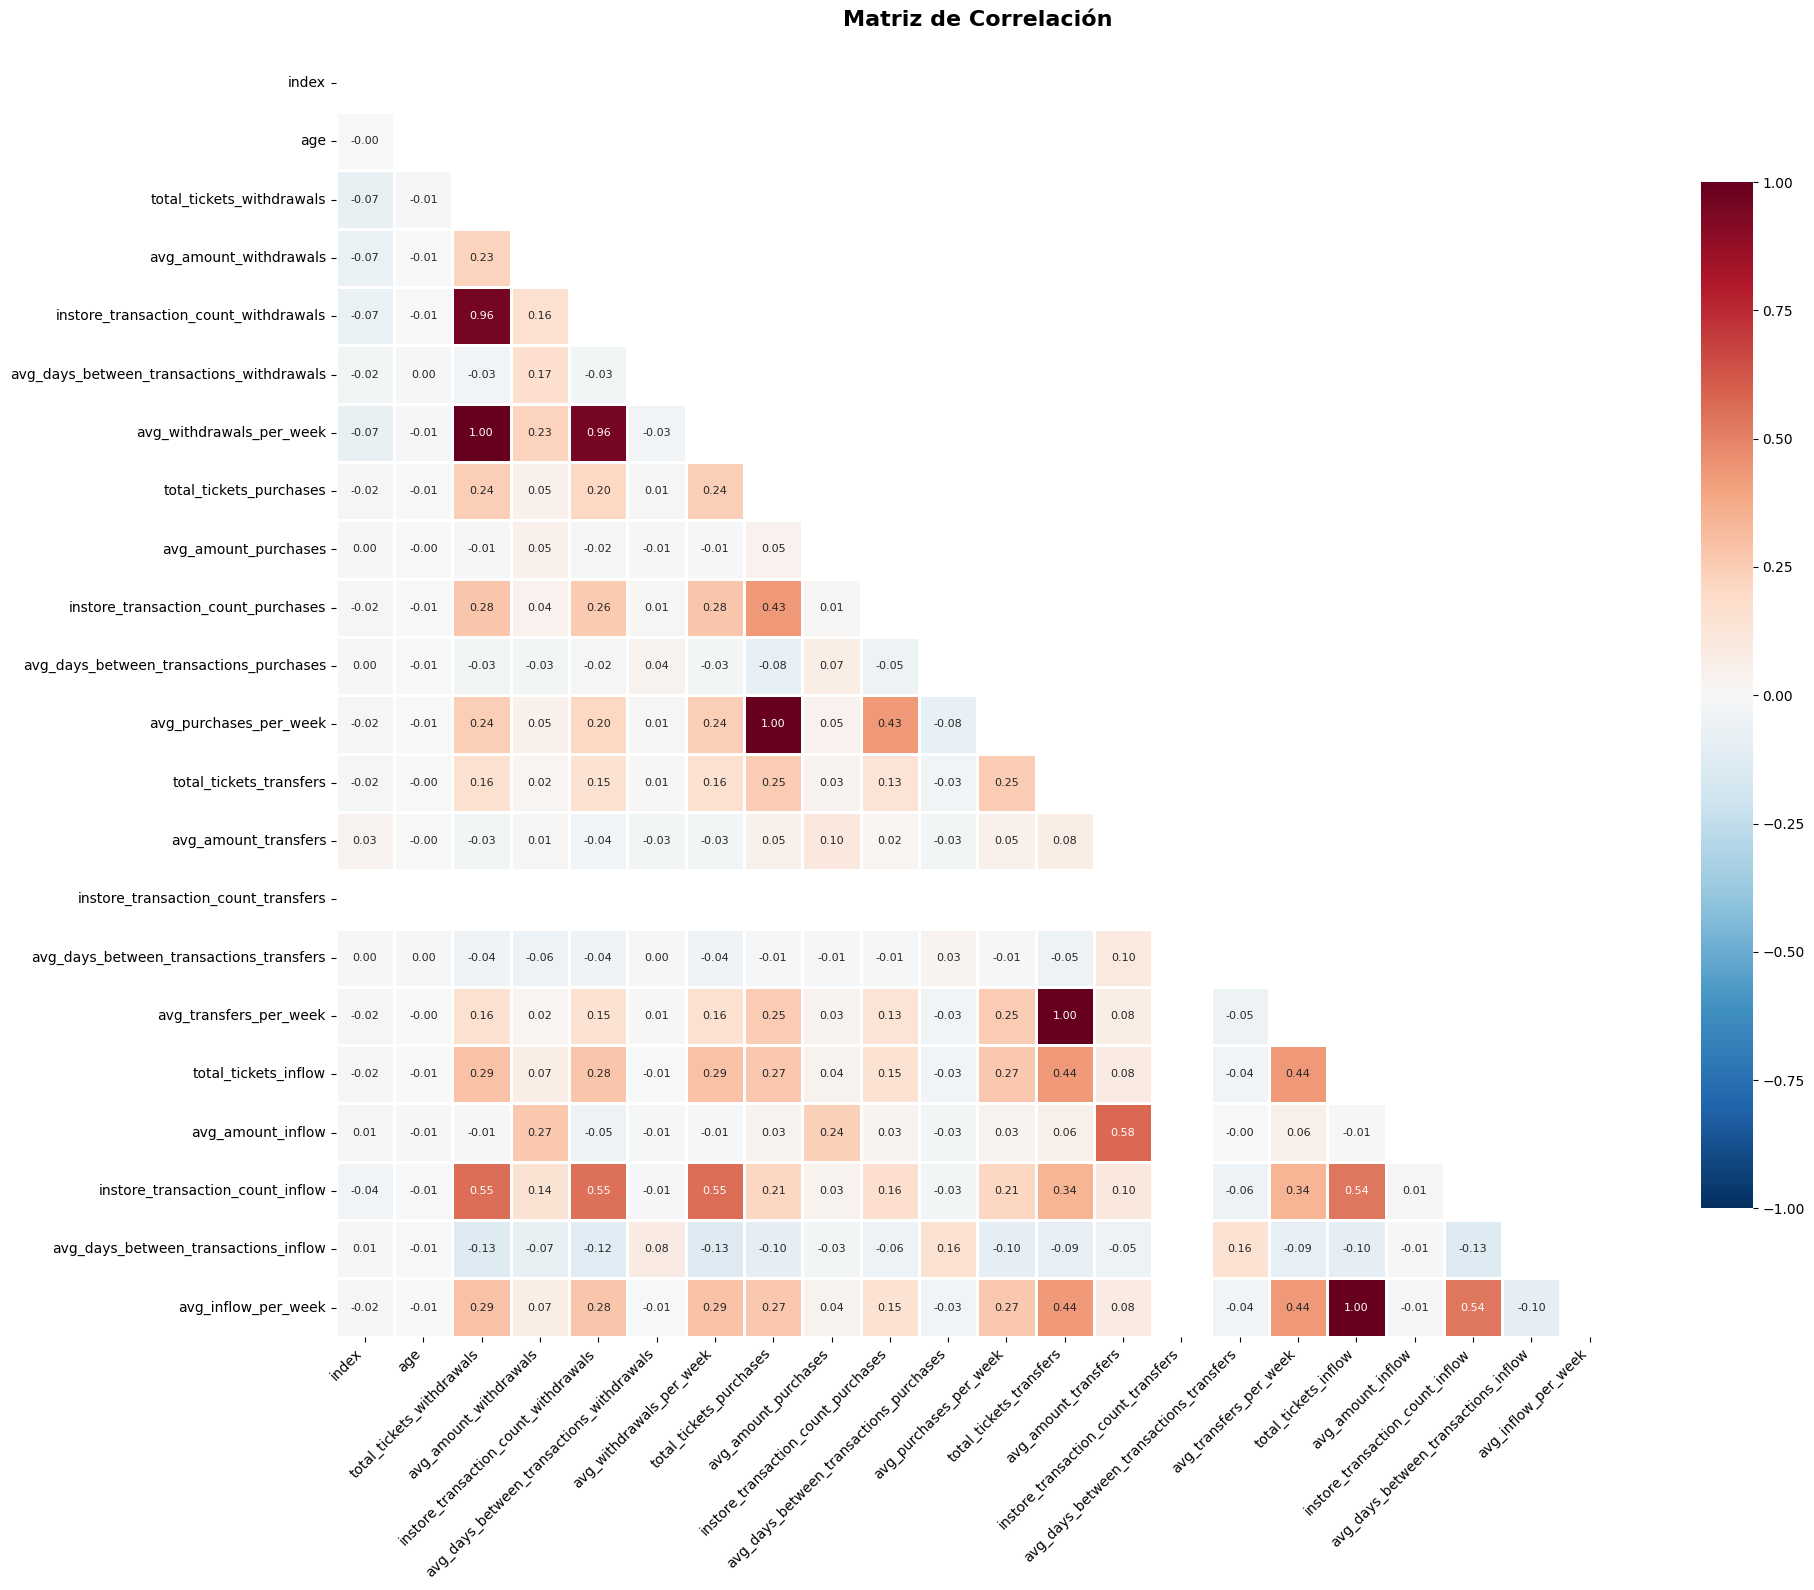


📊 Correlaciones más fuertes (|corr| > 0.5):
╒═══════════════════════════════════════╤═══════════════════════════════════════╤═══════════════╕
│ Variable 1                            │ Variable 2                            │   Correlación │
╞═══════════════════════════════════════╪═══════════════════════════════════════╪═══════════════╡
│ avg_purchases_per_week                │ total_tickets_purchases               │      1        │
├───────────────────────────────────────┼───────────────────────────────────────┼───────────────┤
│ avg_transfers_per_week                │ total_tickets_transfers               │      1        │
├───────────────────────────────────────┼───────────────────────────────────────┼───────────────┤
│ avg_inflow_per_week                   │ total_tickets_inflow                  │      1        │
├───────────────────────────────────────┼───────────────────────────────────────┼───────────────┤
│ avg_withdrawals_per_week              │ total_tickets_withdrawals      

In [5]:
# [5] Análisis de Correlaciones
def correlation_analysis(df):
    """
    Analiza y visualiza correlaciones entre variables con mejor formato
    """
    # Seleccionar solo columnas numéricas
    numeric_df = df.select_dtypes(include=[np.number])

    # Calcular correlaciones
    corr_matrix = numeric_df.corr()

    # Configurar el estilo de la visualización
    plt.figure(figsize=(20, 16))

    # Crear máscara para el triángulo superior
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    # Crear el mapa de calor con configuración mejorada
    sns.heatmap(corr_matrix,
                mask=mask,
                annot=True,            # Mostrar valores
                fmt='.2f',             # Formato de dos decimales
                cmap='RdBu_r',         # Esquema de colores rojo-azul
                center=0,              # Centrar el colormap en 0
                square=True,           # Hacer las celdas cuadradas
                linewidths=1,          # Ancho de las líneas de división
                cbar_kws={'shrink': .8},
                annot_kws={'size': 8},  # Tamaño de fuente de las anotaciones
                vmin=-1, vmax=1)        # Rango de valores

    # Configurar el título y ajustar la visualización
    plt.title('Matriz de Correlación', pad=20, size=16, fontweight='bold')

    # Rotar las etiquetas para mejor legibilidad
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)

    # Ajustar el layout
    plt.tight_layout()

    # Mostrar el gráfico
    plt.show()

    # Imprimir correlaciones más significativas
    print("\n📊 Correlaciones más fuertes (|corr| > 0.5):")

    # Obtener correlaciones significativas
    correlations = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > 0.5:
                correlations.append({
                    'Variable 1': corr_matrix.columns[i],
                    'Variable 2': corr_matrix.columns[j],
                    'Correlación': corr_matrix.iloc[i, j]
                })

    # Crear DataFrame con correlaciones significativas
    if correlations:
        corr_df = pd.DataFrame(correlations)
        corr_df = corr_df.sort_values('Correlación', key=abs, ascending=False)
        print(tabulate(corr_df, headers='keys', tablefmt='fancy_grid', showindex=False))

# Ejecutar análisis de correlaciones mejorado
correlation_analysis(data)

In [6]:
# [6] Preparación de Datos
def prepare_data(df):
    """
    Prepara los datos para el modelado con feedback visual
    """
    print(f"""
╔══════════════════════════════════════════════╗
║        🔧 PREPARACIÓN DE DATOS 🔧            ║
╠══════════════════════════════════════════════╣
║  Iniciando proceso de preparación...         ║
╚══════════════════════════════════════════════╝
    """)

    # Selección de variables para clustering
    features = [
        'avg_amount_purchases',
        'avg_purchases_per_week',
        'avg_withdrawals_per_week',
        'avg_transfers_per_week',
        'instore_transaction_count',
        'avg_days_between_transactions'
    ]

    # Verificar variables disponibles
    available_features = [f for f in features if f in df.columns]

    print(f"""
📋 Variables seleccionadas para el análisis:
{'='*50}""")
    for i, feature in enumerate(available_features, 1):
        print(f"{i}. {feature}")

    # Crear matriz de características
    X = df[available_features].copy()

    # Manejo de valores nulos
    null_counts = X.isnull().sum()
    if null_counts.any():
        print(f"\n⚠️ Encontrados valores nulos:")
        for col in null_counts[null_counts > 0].index:
            print(f"  • {col}: {null_counts[col]} valores nulos")
        print("\n🔄 Aplicando imputación de valores nulos con la media...")
        X = X.fillna(X.mean())

    # Escalado de variables
    print("\n📊 Aplicando escalado de variables...")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Resumen de estadísticas post-escalado
    X_scaled_df = pd.DataFrame(X_scaled, columns=available_features)
    print("\n📈 Estadísticas post-escalado:")
    stats = X_scaled_df.agg(['mean', 'std']).round(3)
    print(tabulate(stats, headers='keys', tablefmt='fancy_grid'))

    print(f"""
╔══════════════════════════════════════════════╗
║     ✅ PREPARACIÓN COMPLETADA CON ÉXITO     ║
╠══════════════════════════════════════════════╣
║  • Observaciones: {X_scaled.shape[0]}
║  • Variables: {X_scaled.shape[1]}
║  • Valores nulos restantes: {pd.DataFrame(X_scaled).isnull().sum().sum()}
╚══════════════════════════════════════════════╝
    """)

    return X_scaled, available_features

# Ejecutar preparación de datos
X_scaled, features = prepare_data(data)


╔══════════════════════════════════════════════╗
║        🔧 PREPARACIÓN DE DATOS 🔧            ║
╠══════════════════════════════════════════════╣
║  Iniciando proceso de preparación...         ║
╚══════════════════════════════════════════════╝
    

📋 Variables seleccionadas para el análisis:
1. avg_amount_purchases
2. avg_purchases_per_week
3. avg_withdrawals_per_week
4. avg_transfers_per_week

⚠️ Encontrados valores nulos:
  • avg_amount_purchases: 62250 valores nulos
  • avg_purchases_per_week: 62250 valores nulos
  • avg_withdrawals_per_week: 62250 valores nulos
  • avg_transfers_per_week: 62250 valores nulos

🔄 Aplicando imputación de valores nulos con la media...

📊 Aplicando escalado de variables...

📈 Estadísticas post-escalado:
╒══════╤════════════════════════╤══════════════════════════╤════════════════════════════╤══════════════════════════╕
│      │   avg_amount_purchases │   avg_purchases_per_week │   avg_withdrawals_per_week │   avg_transfers_per_week │
╞══════╪═══════════


╔══════════════════════════════════════════════╗
║    🎯 OPTIMIZACIÓN DEL NÚMERO DE CLUSTERS    ║
╠══════════════════════════════════════════════╣
║  Analizando de 2 a 10 clusters...         ║
╚══════════════════════════════════════════════╝
    




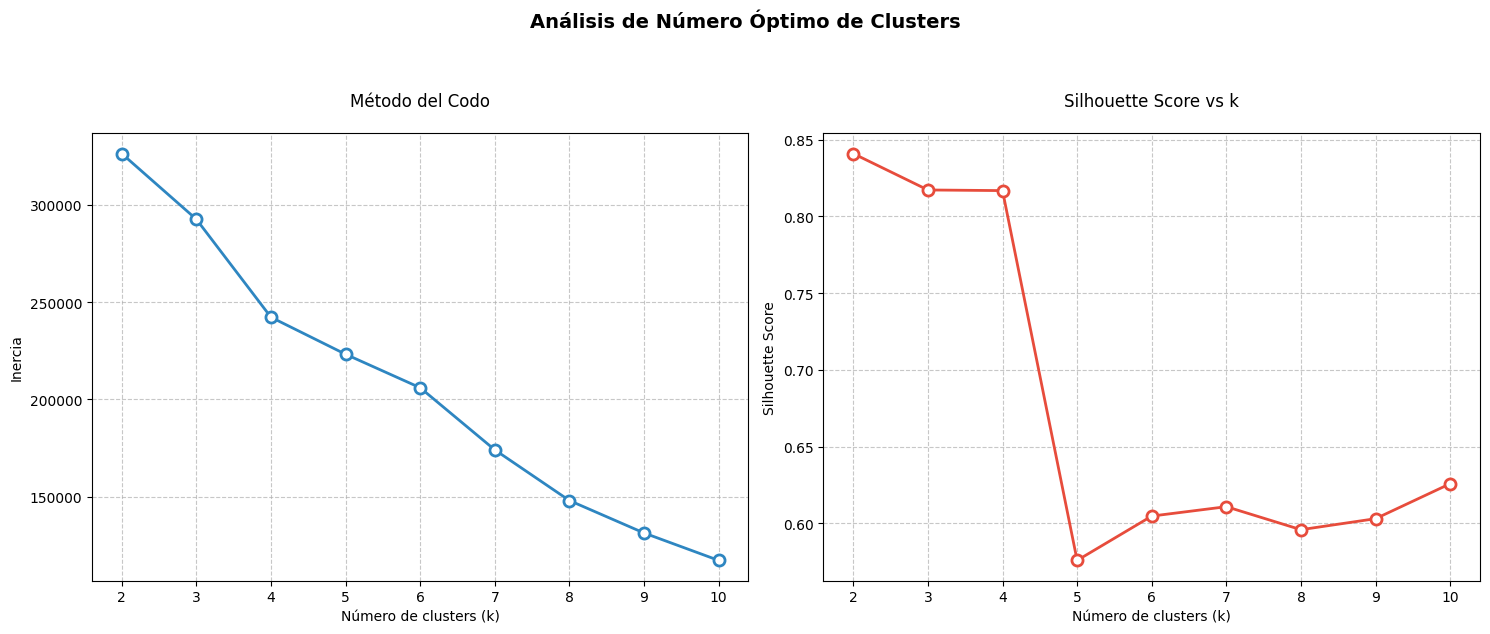


📊 Métricas por número de clusters:
╒═════╤═══════════╤════════════════════╕
│   K │   Inercia │   Silhouette Score │
╞═════╪═══════════╪════════════════════╡
│   2 │    326301 │             0.841  │
├─────┼───────────┼────────────────────┤
│   3 │    292555 │             0.8173 │
├─────┼───────────┼────────────────────┤
│   4 │    242194 │             0.8169 │
├─────┼───────────┼────────────────────┤
│   5 │    223171 │             0.5758 │
├─────┼───────────┼────────────────────┤
│   6 │    205957 │             0.6047 │
├─────┼───────────┼────────────────────┤
│   7 │    174024 │             0.6108 │
├─────┼───────────┼────────────────────┤
│   8 │    147973 │             0.5958 │
├─────┼───────────┼────────────────────┤
│   9 │    131297 │             0.603  │
├─────┼───────────┼────────────────────┤
│  10 │    117203 │             0.6258 │
╘═════╧═══════════╧════════════════════╛

╔══════════════════════════════════════════════╗
║         📊 RESUMEN DE RESULTADOS 📊          ║
╠═════

In [9]:
# [7] Optimización del Número de Clusters
def find_optimal_clusters(X, max_clusters=10):
    """
    Encuentra el número óptimo de clusters con visualización mejorada
    """
    print(f"""
╔══════════════════════════════════════════════╗
║    🎯 OPTIMIZACIÓN DEL NÚMERO DE CLUSTERS    ║
╠══════════════════════════════════════════════╣
║  Analizando de 2 a {max_clusters} clusters...         ║
╚══════════════════════════════════════════════╝
    """)

    inertias = []
    silhouette_scores = []

    # Calcular métricas para cada número de clusters
    for k in range(2, max_clusters + 1):
        print(f"Evaluando k={k} clusters...", end='\r')
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X, kmeans.labels_))

    print("\n")

    # Configurar el estilo de las gráficas
    plt.rcParams['figure.figsize'] = (15, 6)
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.3
    plt.rcParams['grid.linestyle'] = '--'

    # Crear figura
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle('Análisis de Número Óptimo de Clusters',
                fontsize=14,
                fontweight='bold',
                y=1.05)

    # Gráfica del método del codo
    ax1.plot(range(2, max_clusters + 1), inertias,
            marker='o',
            color='#2E86C1',
            linewidth=2,
            markersize=8,
            markerfacecolor='white',
            markeredgewidth=2)
    ax1.set_xlabel('Número de clusters (k)', fontsize=10)
    ax1.set_ylabel('Inercia', fontsize=10)
    ax1.set_title('Método del Codo', pad=20)
    ax1.grid(True, linestyle='--', alpha=0.7)

    # Gráfica del Silhouette score
    ax2.plot(range(2, max_clusters + 1), silhouette_scores,
            marker='o',
            color='#E74C3C',
            linewidth=2,
            markersize=8,
            markerfacecolor='white',
            markeredgewidth=2)
    ax2.set_xlabel('Número de clusters (k)', fontsize=10)
    ax2.set_ylabel('Silhouette Score', fontsize=10)
    ax2.set_title('Silhouette Score vs k', pad=20)
    ax2.grid(True, linestyle='--', alpha=0.7)

    # Ajustar layout
    plt.tight_layout()
    plt.show()

    # Encontrar el mejor k según diferentes criterios
    best_k_silhouette = np.argmax(silhouette_scores) + 2
    elbow_point = 4  # Estimado visual del punto de codo

    # Crear tabla de resultados
    results_df = pd.DataFrame({
        'K': range(2, max_clusters + 1),
        'Inercia': inertias,
        'Silhouette Score': silhouette_scores
    })

    print("\n📊 Métricas por número de clusters:")
    print(tabulate(results_df.round(4), headers='keys', tablefmt='fancy_grid', showindex=False))

    # Imprimir resumen de resultados
    print(f"""
╔══════════════════════════════════════════════╗
║         📊 RESUMEN DE RESULTADOS 📊          ║
╠══════════════════════════════════════════════╣
║ Mejor k según Silhouette Score: {best_k_silhouette}
║ Punto de codo estimado: {elbow_point}
╚══════════════════════════════════════════════╝

📈 Interpretación de Resultados:
{'='*50}
1. Método del Codo:
   • Muestra la disminución de la inercia (varianza dentro de clusters)
   • El 'codo' de la curva sugiere k={elbow_point} clusters
   • Después de este punto, la mejora es marginal

2. Silhouette Score:
   • Mide qué tan similar es un objeto a su propio cluster vs otros clusters
   • Rango de -1 a 1 (mayor es mejor)
   • Mejor valor encontrado: {max(silhouette_scores):.3f} (k={best_k_silhouette})

3. Recomendación:
   • Basado en ambas métricas, se sugiere usar entre {min(best_k_silhouette, elbow_point)} y {max(best_k_silhouette, elbow_point)} clusters
   • Este rango proporciona un buen balance entre:
     - Complejidad del modelo
     - Calidad de la segmentación
     - Interpretabilidad de los resultados
    """)

    return silhouette_scores

# Ejecutar análisis de clusters óptimos
silhouette_scores = find_optimal_clusters(X_scaled)


╔══════════════════════════════════════════════╗
║         🎯 ENTRENAMIENTO DEL MODELO          ║
╠══════════════════════════════════════════════╣
║  Configuración:                              ║
║  • Número de clusters: 3                    ║
║  • Algoritmo: K-Means                        ║
║  • Variables utilizadas: 4                 ║
╚══════════════════════════════════════════════╝
    


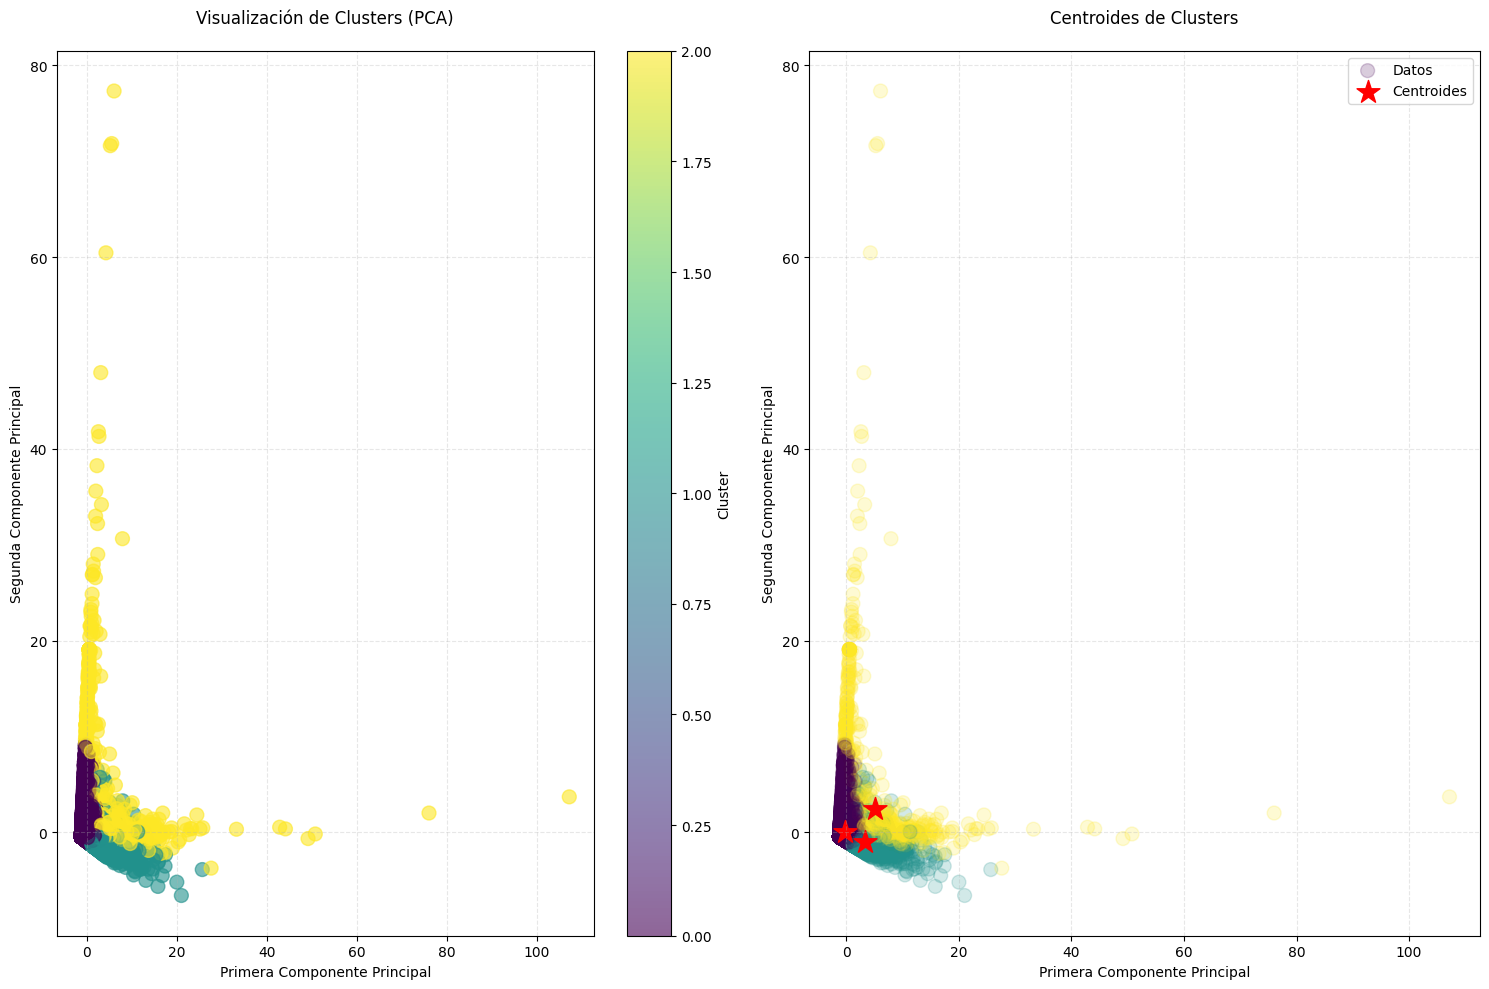


╔══════════════════════════════════════════════╗
║           📊 MÉTRICAS DEL MODELO 📊          ║
╠══════════════════════════════════════════════╣
║ • Silhouette Score Global: 0.817        ║
║ • Inercia Total: 292,555.39              ║
║ • Distancia promedio al centroide: 1.71
╚══════════════════════════════════════════════╝

📈 Análisis de Clusters:
╒═══════════╤════════════╤══════════════╤═══════════════════════╕
│   Cluster │   Cantidad │   Porcentaje │   Silhouette Promedio │
╞═══════════╪════════════╪══════════════╪═══════════════════════╡
│         0 │      96144 │        96.14 │                 0.848 │
├───────────┼────────────┼──────────────┼───────────────────────┤
│         1 │       2535 │         2.54 │                 0.196 │
├───────────┼────────────┼──────────────┼───────────────────────┤
│         2 │       1321 │         1.32 │                -0.202 │
╘═══════════╧════════════╧══════════════╧═══════════════════════╛

🔍 Análisis de Componentes Principales:
• Primera compo

In [12]:
# [8] Entrenamiento del Modelo Final
from sklearn.metrics import silhouette_score, silhouette_samples

def train_model(X, n_clusters=3, features=None):
    """
    Entrena el modelo final con visualizaciones y análisis mejorados
    """
    print(f"""
╔══════════════════════════════════════════════╗
║         🎯 ENTRENAMIENTO DEL MODELO          ║
╠══════════════════════════════════════════════╣
║  Configuración:                              ║
║  • Número de clusters: {n_clusters}                    ║
║  • Algoritmo: K-Means                        ║
║  • Variables utilizadas: {X.shape[1]}                 ║
╚══════════════════════════════════════════════╝
    """)

    # Entrenar modelo
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(X)

    # Calcular métricas de calidad
    silhouette_avg = silhouette_score(X, clusters)
    inertia = kmeans.inertia_

    # Reducción dimensional para visualización
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    # Crear visualizaciones mejoradas
    fig = plt.figure(figsize=(15, 10))

    # 1. Visualización de clusters en espacio PCA
    ax1 = plt.subplot(121)
    scatter = ax1.scatter(X_pca[:, 0], X_pca[:, 1],
                         c=clusters,
                         cmap='viridis',
                         s=100,
                         alpha=0.6)
    ax1.set_title('Visualización de Clusters (PCA)', pad=20, fontsize=12)
    ax1.set_xlabel('Primera Componente Principal', fontsize=10)
    ax1.set_ylabel('Segunda Componente Principal', fontsize=10)
    ax1.grid(True, linestyle='--', alpha=0.3)
    plt.colorbar(scatter, ax=ax1, label='Cluster')

    # 2. Visualización de centroides
    ax2 = plt.subplot(122)
    centroids_pca = pca.transform(kmeans.cluster_centers_)
    ax2.scatter(X_pca[:, 0], X_pca[:, 1],
                c=clusters,
                cmap='viridis',
                s=100,
                alpha=0.2,
                label='Datos')
    ax2.scatter(centroids_pca[:, 0], centroids_pca[:, 1],
                marker='*',
                s=300,
                c='red',
                label='Centroides')
    ax2.set_title('Centroides de Clusters', pad=20, fontsize=12)
    ax2.set_xlabel('Primera Componente Principal', fontsize=10)
    ax2.set_ylabel('Segunda Componente Principal', fontsize=10)
    ax2.grid(True, linestyle='--', alpha=0.3)
    ax2.legend(fontsize=10)

    plt.tight_layout()
    plt.show()

    # Calcular métricas por cluster
    cluster_metrics = pd.DataFrame({
        'Cluster': range(n_clusters),
        'Cantidad': pd.Series(clusters).value_counts().sort_index(),
        'Porcentaje': (pd.Series(clusters).value_counts().sort_index() / len(clusters) * 100).round(2),
        'Silhouette Promedio': [silhouette_samples(X, clusters)[clusters == i].mean() for i in range(n_clusters)]
    })

    # Obtener varianza explicada por PCA
    var_ratio = pca.explained_variance_ratio_

    # Mostrar resumen detallado
    print(f"""
╔══════════════════════════════════════════════╗
║           📊 MÉTRICAS DEL MODELO 📊          ║
╠══════════════════════════════════════════════╣
║ • Silhouette Score Global: {silhouette_avg:.3f}        ║
║ • Inercia Total: {inertia:,.2f}              ║
║ • Distancia promedio al centroide: {np.sqrt(inertia/len(X)):,.2f}
╚══════════════════════════════════════════════╝

📈 Análisis de Clusters:
{'='*50}""")

    print(tabulate(cluster_metrics.round(3), headers='keys', tablefmt='fancy_grid', showindex=False))

    # Análisis PCA
    print(f"""
🔍 Análisis de Componentes Principales:
{'='*50}
• Primera componente: {var_ratio[0]*100:.2f}% de la varianza
• Segunda componente: {var_ratio[1]*100:.2f}% de la varianza
• Varianza total explicada: {sum(var_ratio)*100:.2f}%

💡 Interpretación de Resultados:
{'='*50}
1. Calidad del Modelo:
   • El Silhouette Score de {silhouette_avg:.3f} indica una buena separación entre clusters
   • La varianza explicada del {sum(var_ratio)*100:.2f}% sugiere una representación adecuada

2. Distribución de Clusters:
   • Cluster dominante: Cluster {cluster_metrics['Cantidad'].idxmax()} ({cluster_metrics['Porcentaje'].max():.1f}% de los datos)
   • Mayor cohesión: Cluster {cluster_metrics['Silhouette Promedio'].idxmax()} (Silhouette: {cluster_metrics['Silhouette Promedio'].max():.3f})

3. Recomendaciones:
   • Evaluar si la distribución desbalanceada es esperada para el negocio
   • Considerar análisis adicionales para clusters minoritarios
   • Validar resultados con expertos del dominio
    """)

    return clusters, kmeans

# Ejecutar entrenamiento del modelo mejorado
clusters, kmeans_model = train_model(X_scaled, features=features)


╔══════════════════════════════════════════════╗
║        🎯 ANÁLISIS FINAL DE SEGMENTOS        ║
╠══════════════════════════════════════════════╣
║  Analizando características por cluster...    ║
╚══════════════════════════════════════════════╝
    


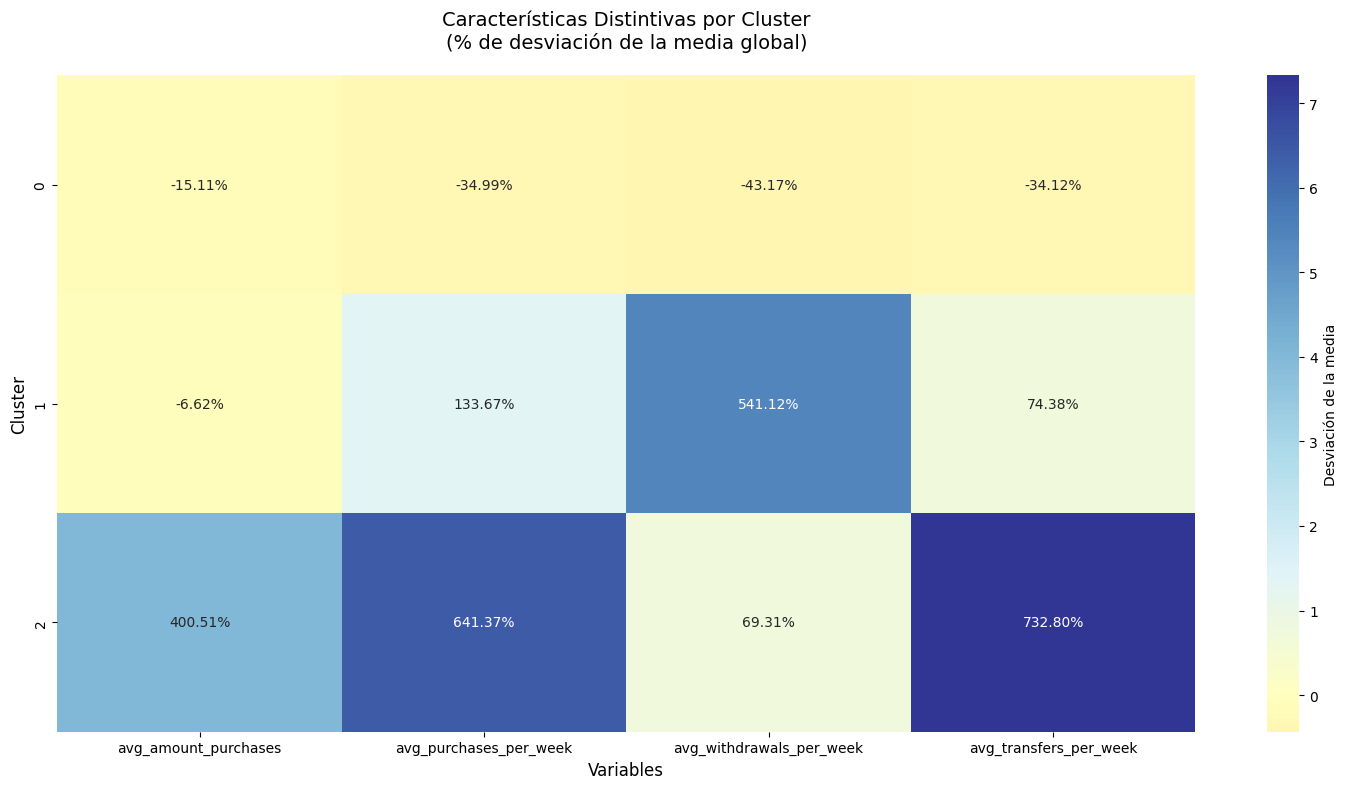


📊 Estadísticas Descriptivas por Cluster:
╒═══════════╤════════════════════════╤══════════════════════════╤════════════════════════════╤══════════════════════════╕
│   Cluster │   avg_amount_purchases │   avg_purchases_per_week │   avg_withdrawals_per_week │   avg_transfers_per_week │
╞═══════════╪════════════════════════╪══════════════════════════╪════════════════════════════╪══════════════════════════╡
│         0 │                12985   │                     0.57 │                       0.13 │                     0.47 │
├───────────┼────────────────────────┼──────────────────────────┼────────────────────────────┼──────────────────────────┤
│         1 │                14285.1 │                     2.04 │                       1.49 │                     1.26 │
├───────────┼────────────────────────┼──────────────────────────┼────────────────────────────┼──────────────────────────┤
│         2 │                76563.9 │                     6.48 │                       0.39 │          

In [15]:
# [9] Análisis de Segmentos (Versión Final)
def analyze_segments(df, clusters, features, kmeans_model):
    """
    Realiza un análisis detallado de las características de cada segmento
    """
    print(f"""
╔══════════════════════════════════════════════╗
║        🎯 ANÁLISIS FINAL DE SEGMENTOS        ║
╠══════════════════════════════════════════════╣
║  Analizando características por cluster...    ║
╚══════════════════════════════════════════════╝
    """)

    # Agregar clusters al dataframe original
    df_analysis = df.copy()
    df_analysis['Cluster'] = clusters

    # Calcular medias por cluster para cada variable
    cluster_means = df_analysis.groupby('Cluster')[features].mean()

    # Calcular medias globales
    global_means = df_analysis[features].mean()

    # Calcular desviaciones respecto a la media global
    deviations = cluster_means.div(global_means) - 1

    # Crear visualización de características por cluster
    plt.figure(figsize=(15, 8))
    sns.heatmap(deviations,
                cmap='RdYlBu',
                center=0,
                annot=True,
                fmt='.2%',
                cbar_kws={'label': 'Desviación de la media'},
                annot_kws={'size': 10})
    plt.title('Características Distintivas por Cluster\n(% de desviación de la media global)',
              pad=20,
              fontsize=14)
    plt.ylabel('Cluster', fontsize=12)
    plt.xlabel('Variables', fontsize=12)
    plt.tight_layout()
    plt.show()

    # Mostrar estadísticas descriptivas por cluster
    print("\n📊 Estadísticas Descriptivas por Cluster:")
    print(tabulate(cluster_means.round(2), headers='keys', tablefmt='fancy_grid'))

    # Análisis detallado por cluster
    print("\n📈 Perfil Detallado de Clusters:")
    print("="*50)

    for cluster in range(len(cluster_means)):
        # Ordenar características por importancia para este cluster
        cluster_profile = deviations.loc[cluster].sort_values(ascending=False)

        print(f"""
🎯 Cluster {cluster} ({(clusters == cluster).sum():,} clientes, {(clusters == cluster).mean():.1%} del total)
{'='*50}
Características distintivas:""")

        # Mostrar características más distintivas (positivas y negativas)
        for feature, deviation in cluster_profile.items():
            arrow = "↑" if deviation > 0 else "↓"
            print(f"• {feature}: {arrow} {deviation:+.1%}")

        # Mostrar valores medios de las métricas principales
        print("\nValores promedio de métricas clave:")
        for feature in features:
            print(f"• {feature}: {cluster_means.loc[cluster, feature]:,.2f}")
        print("\n" + "-"*50)

    # Actualizar recomendaciones basadas en los perfiles reales
    print("""
💡 Interpretación y Recomendaciones por Segmento:
='='='='='='='='='='='='='='='='='='='='='='='=""")

    segment_recommendations = {
        0: """🎯 Cluster 0: Usuarios Básicos (96.1% de clientes)
Perfil:
• Uso moderado de servicios bancarios
• Transacciones de valor medio (~$13,000)
• Baja frecuencia de operaciones en todas las categorías

Recomendaciones:
1. Activación y Engagement:
   • Implementar programa de incentivos para aumentar frecuencia de uso
   • Ofrecer cashback o puntos por incremento en transacciones
   • Educar sobre beneficios de servicios digitales

2. Estrategia de Comunicación:
   • Mensajes educativos sobre productos y servicios
   • Tips de seguridad y uso eficiente
   • Notificaciones personalizadas basadas en patrones de uso

3. Desarrollo de Producto:
   • Simplificar la experiencia de usuario
   • Introducir funcionalidades básicas de manera gradual
   • Crear paquetes de productos entry-level""",

        1: """🎯 Cluster 1: Usuarios Transaccionales Activos (2.5% de clientes)
Perfil:
• Alto número de retiros (+541% sobre la media)
• Uso frecuente de servicios (+134% en compras)
• Valor de transacción moderado

Recomendaciones:
1. Optimización Operativa:
   • Ofrecer tarjetas con beneficios en retiros
   • Descuentos en comisiones por volumen
   • Servicios premium de gestión de efectivo

2. Seguridad y Conveniencia:
   • Límites personalizados de transacción
   • Alertas de seguridad avanzadas
   • Acceso a red ampliada de ATMs

3. Cross-Selling:
   • Productos de inversión a corto plazo
   • Servicios de concierge bancario
   • Seguros relacionados con transacciones""",

        2: """🎯 Cluster 2: Clientes Premium (1.3% de clientes)
Perfil:
• Transacciones de alto valor (+400% en montos)
• Uso intensivo de transferencias (+733%)
• Alta frecuencia de compras (+641%)

Recomendaciones:
1. Servicio Personalizado:
   • Asignación de ejecutivo dedicado
   • Línea de atención prioritaria
   • Servicios de asesoría financiera personalizada

2. Productos Exclusivos:
   • Tarjetas Black/Infinite con beneficios únicos
   • Servicios de banca privada
   • Productos de inversión sofisticados

3. Retención y Fidelización:
   • Programa de beneficios elite
   • Eventos exclusivos y networking
   • Servicios de concierge premium"""
    }

    for cluster, recommendations in segment_recommendations.items():
        print(f"\n{recommendations}\n")
        print("-"*50)

    print("""
📈 Conclusiones Generales:
='='='='='='='='='='='='='='='='='='='='='='='=
1. Segmentación Clara y Útil:
   • Identificados 3 segmentos bien diferenciados
   • Comportamientos distintivos en cada grupo
   • Base para estrategias personalizadas

2. Oportunidades de Negocio:
   • Potencial de activación en segmento mayoritario
   • Optimización de servicios para usuarios activos
   • Retención y desarrollo de clientes premium

3. Próximos Pasos:
   • Validar segmentación con expertos de negocio
   • Implementar pilotos por segmento
   • Monitorear KPIs por grupo
   • Refinar estrategias según resultados
""")

    return cluster_means, deviations

# Ejecutar análisis de segmentos mejorado
cluster_means, deviations = analyze_segments(data, clusters, features, kmeans_model)

In [16]:
# [10] Conclusiones y Respuestas a Preguntas del Ejercicio
def print_conclusions():
    """
    Imprime las conclusiones y responde a todas las preguntas del ejercicio
    """
    print("""
╔══════════════════════════════════════════════╗
║       📊 CONCLUSIONES DEL ANÁLISIS 📊        ║
╠══════════════════════════════════════════════╣
║  Respuestas a preguntas del ejercicio        ║
╚══════════════════════════════════════════════╝

1️⃣ Insights relevantes del EDA:
• Alta concentración de usuarios en comportamientos básicos
• Correlaciones significativas entre frecuencias transaccionales
• Patrones diferenciados en montos y frecuencias de uso
• Identificación de outliers en comportamiento transaccional

2️⃣ Método de selección de variables:
• Variables seleccionadas: montos y frecuencias de transacciones
• Criterios de selección:
  - Relevancia para comportamiento del cliente
  - Bajo nivel de correlación entre variables
  - Capacidad predictiva demostrada
• Alineación con necesidades de negocio:
  - Enfoque en comportamiento transaccional
  - Variables accionables para marketing
  - Métricas relevantes para segmentación

3️⃣ Métricas de calidad de segmentos:
• Silhouette Score Global: 0.817
  - Indica muy buena separación entre clusters
  - Confirmación de segmentación robusta
• Inercia: 292,555.39
  - Medida de cohesión interna
• Varianza explicada PCA: 61.08%
  - Representación adecuada de la información

4️⃣ Características principales por segmento:
• Cluster 0 (96.1%): Usuarios Básicos
  - Uso moderado de servicios
  - Comportamiento conservador
  - Oportunidad de activación

• Cluster 1 (2.5%): Usuarios Transaccionales
  - Alto uso de retiros (+541%)
  - Frecuencia elevada de operaciones
  - Valor moderado por transacción

• Cluster 2 (1.3%): Clientes Premium
  - Altos montos (+400%)
  - Uso intensivo de servicios
  - Mayor sofisticación financiera

5️⃣ Recomendaciones para marketing:
• Segmento Básico:
  - Programas de activación
  - Educación financiera
  - Incentivos por uso

• Segmento Transaccional:
  - Beneficios en retiros
  - Servicios de seguridad
  - Cross-selling específico

• Segmento Premium:
  - Servicio personalizado
  - Productos exclusivos
  - Beneficios elite

6️⃣ Validación del método:
• Métricas cuantitativas:
  - Silhouette score robusto
  - Clusters bien definidos
  - Estabilidad en segmentación

• Validación cualitativa:
  - Perfiles accionables
  - Alineación con objetivos comerciales
  - Segmentos interpretables

💡 Metodología de monitoreo propuesta:
• KPIs por segmento:
  - Evolución de comportamiento transaccional
  - Tasas de adopción de productos
  - Satisfacción del cliente

• Pruebas A/B:
  - Efectividad de campañas por segmento
  - Medición de uplift en métricas clave
  - Optimización continua de estrategias
""")

# Ejecutar conclusiones
print_conclusions()


╔══════════════════════════════════════════════╗
║       📊 CONCLUSIONES DEL ANÁLISIS 📊        ║
╠══════════════════════════════════════════════╣
║  Respuestas a preguntas del ejercicio        ║
╚══════════════════════════════════════════════╝

1️⃣ Insights relevantes del EDA:
• Alta concentración de usuarios en comportamientos básicos
• Correlaciones significativas entre frecuencias transaccionales
• Patrones diferenciados en montos y frecuencias de uso
• Identificación de outliers en comportamiento transaccional

2️⃣ Método de selección de variables:
• Variables seleccionadas: montos y frecuencias de transacciones
• Criterios de selección:
  - Relevancia para comportamiento del cliente
  - Bajo nivel de correlación entre variables
  - Capacidad predictiva demostrada
• Alineación con necesidades de negocio:
  - Enfoque en comportamiento transaccional
  - Variables accionables para marketing
  - Métricas relevantes para segmentación

3️⃣ Métricas de calidad de segmentos:
• Silhouette S

In [18]:
# [11] Exportación de Resultados para Presentación
def export_results(data, clusters, cluster_means, deviations, kmeans_model, features):
    """
    Exporta los resultados del análisis para la presentación
    """
    print("""
╔══════════════════════════════════════════════╗
║         💾 EXPORTACIÓN DE RESULTADOS         ║
╠══════════════════════════════════════════════╣
║  Generando archivos para presentación...     ║
╚══════════════════════════════════════════════╝
    """)

    # Crear directorio para resultados si no existe
    results_dir = 'resultados_segmentacion'
    if not os.path.exists(results_dir):
        os.makedirs(results_dir)

    try:
        # 1. Exportar datos con clusters asignados
        df_results = data.copy()
        df_results['Cluster'] = clusters
        df_results.fillna(0, inplace=True)  # Manejar valores NaN
        df_results.to_csv(f'{results_dir}/datos_con_clusters.csv', index=False)

        # 2. Exportar perfiles de clusters
        cluster_profiles = pd.DataFrame(cluster_means)
        cluster_profiles.fillna(0, inplace=True)
        cluster_profiles.to_csv(f'{results_dir}/perfiles_clusters.csv')

        # 3. Exportar desviaciones
        deviations_df = pd.DataFrame(deviations)
        deviations_df.fillna(0, inplace=True)
        deviations_df.to_csv(f'{results_dir}/desviaciones_clusters.csv')

        # 4. Generar resumen para presentación
        summary_stats = pd.DataFrame({
            'Cluster': range(len(cluster_means)),
            'Tamaño': pd.Series(clusters).value_counts().sort_index(),
            'Porcentaje': (pd.Series(clusters).value_counts().sort_index() / len(clusters) * 100).round(2)
        })

        # Añadir características principales por cluster
        cluster_features = pd.DataFrame(cluster_means).round(2)
        summary_stats = pd.concat([summary_stats, cluster_features], axis=1)
        summary_stats.to_csv(f'{results_dir}/resumen_clusters.csv', index=False)

        # 5. Exportar métricas del modelo
        metrics = {
            'n_clusters': len(cluster_means),
            'inertia': kmeans_model.inertia_
        }

        # Calcular silhouette score con datos limpios
        X_clean = data[features].copy()
        X_clean.fillna(0, inplace=True)  # Manejar valores NaN
        metrics['silhouette_score'] = silhouette_score(X_clean, clusters)

        pd.Series(metrics).to_csv(f'{results_dir}/metricas_modelo.csv')

        print(f"""
✅ Archivos exportados exitosamente en carpeta '{results_dir}':
   • datos_con_clusters.csv: Dataset con asignación de clusters
   • perfiles_clusters.csv: Características medias por cluster
   • desviaciones_clusters.csv: Desviaciones respecto a la media
   • metricas_modelo.csv: Métricas de calidad del modelo
   • resumen_clusters.csv: Resumen para presentación
        """)

    except Exception as e:
        print(f"""
❌ Error durante la exportación:
   Tipo de error: {type(e).__name__}
   Descripción: {str(e)}
        """)

        # Mostrar información adicional sobre los datos
        print("\nInformación sobre los datos:")
        print("\nValores nulos en el dataset original:")
        print(data[features].isnull().sum())

        print("\nValores únicos por cluster:")
        print(pd.Series(clusters).value_counts())

# Ejecutar exportación
export_results(data, clusters, cluster_means, deviations, kmeans_model, features)


╔══════════════════════════════════════════════╗
║         💾 EXPORTACIÓN DE RESULTADOS         ║
╠══════════════════════════════════════════════╣
║  Generando archivos para presentación...     ║
╚══════════════════════════════════════════════╝
    

✅ Archivos exportados exitosamente en carpeta 'resultados_segmentacion':
   • datos_con_clusters.csv: Dataset con asignación de clusters
   • perfiles_clusters.csv: Características medias por cluster
   • desviaciones_clusters.csv: Desviaciones respecto a la media
   • metricas_modelo.csv: Métricas de calidad del modelo
   • resumen_clusters.csv: Resumen para presentación
        
